In [2]:
import cv2
import numpy as np
import utils as selfutils
from matplotlib import pyplot as plt
import keras_applications as apps
from keras import backend, layers, models, utils
from keras.models import Model
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # 设置显示图片的大小
# %matplotlib notebook

注意，这里从官网下载模型非常慢，建议预先下载好模型放在对应目录
名称：vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [3]:
model = apps.vgg16.VGG16(weights='D:/pretrainedmodels/vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                         backend=backend,
                         layers=layers,
                         models=models,
                         utils=utils)    # 注意此处用法更新了

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
img = cv2.imread('cat.jpg')
pimg = cv2.resize(img, (224,224))
pimg = np.expand_dims(pimg, axis=0)
pimg = apps.vgg16.preprocess_input(pimg,backend=backend)


(1, 224, 224, 64)


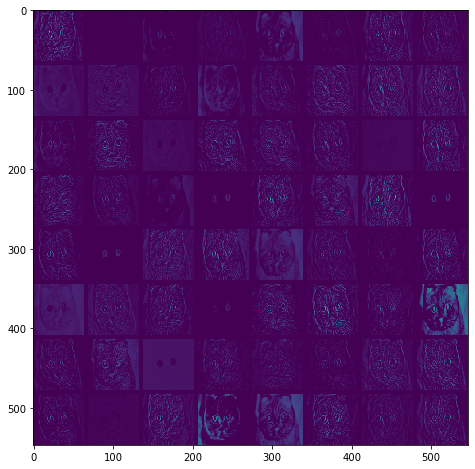

In [6]:
layer_name = 'block1_conv1'    # 在这里指定需要查看的层
input_img = model.input
conv_out = model.get_layer(layer_name).output
tmp_layer_model = Model(inputs=input_img, outputs=conv_out)
tmp_output = tmp_layer_model.predict(pimg)
print(tmp_output.shape)
# 第一种，可视化卷积操作后的结果
selfutils.vis_conv(tmp_output[0],8,layer_name,'conv')

解释CNN模型的另一个简单方法是显示每个卷积核响应的视觉模式, 卷积核可视化通过输入空间中的梯度上升来完成。定义一个损失函数，这个损失函数将用于最大化某个指定滤波器的激活值。以该函数为优化目标优化后，将使用随机梯度下降来调整输入图像的值，以便最大化该激活值。最终损失值较小的结果就能反应出卷积核包含的信息。
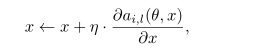
对计算出来的梯度进行L2正则化操作，使得梯度不会过小或过大，可以让梯度上升的过程平滑进行。

(?, 224, 224, 64)


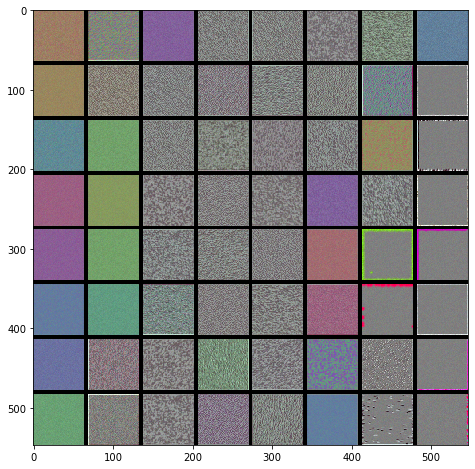

In [7]:
# 第二种,卷积核可视化
layer_name = 'block1_conv2'    # 在这里指定需要查看的层
# 为输入图像准备placeholder
input_img = model.input
# 生成原始随机图像1个,用来被训练
pimg = np.random.random((1, 224, 224, 3)) * 20 + 128.
# 将除第一层以外的每个层打包成字典,层名:层对象
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_output = layer_dict[layer_name].output
kept_filters = []
print(layer_output.shape)
for i in range(layer_output.shape[-1]):
    loss = backend.mean(layer_output[:, :, :, i])
    # 用这个损失计算输入图像的梯度
    grads = backend.gradients(loss, input_img)[0]
    # 对梯度进行正则化 L2
    grads /= (backend.sqrt(backend.mean(backend.square(grads))) + backend.epsilon())
    # 该函数返回给定输入图像的损耗和梯度
    iterate = backend.function([input_img], [loss, grads])
    # 设置学习率
    lr = 1.
    # 注意python深浅拷贝机制
    fimg = pimg.copy()
    # 运行梯度上升20次
    for j in range(20):
        loss_value, grads_value = iterate([fimg])
        fimg += grads_value * lr    
    # 将tensor对象转换为图像
    fimg = selfutils.deprocess_image(fimg[0])
    kept_filters.append((fimg, loss_value))
    # 用损失值，对所有输出的图像进行排序
    kept_filters.sort(key=lambda x: x[1], reverse=True)

result = np.array([f[0] for f in kept_filters])
selfutils.vis_conv(result, 8, layer_name, 'filter')

第三种，直接将网络权重提取出来，并且将各个权重值（原始的卷积核权重包含负数）归一化到0-255之间，然后再可视化
ps: 这里的picnormalize()函数专门为维度信息为`[3,:,:,:]`的卷积核组准备的，这里第一层conv1的信息为`[3,3,3,64]`即 维度=3 宽高=3 数量=64

(3, 3, 3, 64)


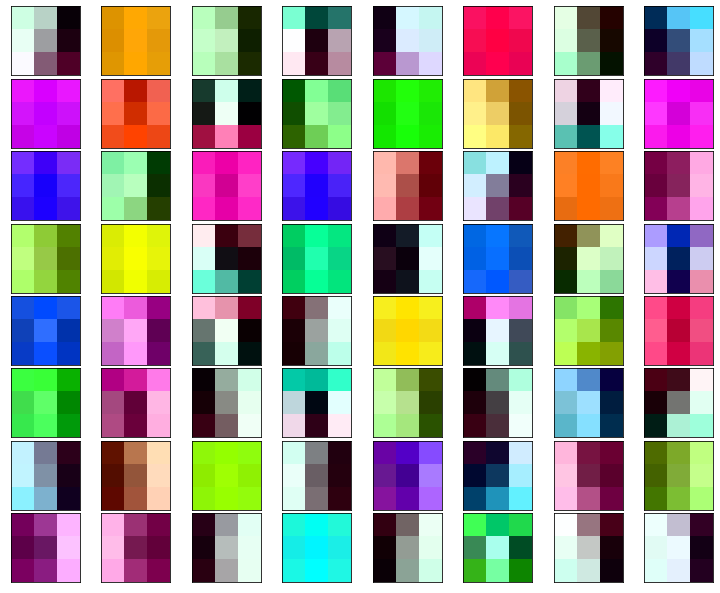

In [8]:
# 第三种，直接将网络权重可视化
layer_name = 'block1_conv1' 
# 首先拿出确定层的权重
weights, bias = model.get_layer(layer_name).get_weights()
print(weights.shape)
normalized = selfutils.picnormalize(weights)
selfutils.filter_show(normalized)